# Домашнее задание: дообучение нейросети



Привет!

В этом домашнем задании вам предстоит самим дообучить сеть на новом датасете для классификации.  

В последнем практическом занятии этого модуля мы решали задачу классификации кошек и собак с помощью предобученной на ImageNet сети. На самом деле, это не совсем честно, потому что среди классов ImageNet наверняка есть классы "кошка" и "собака", и сеть, обученная на ImageNet и без дообучения может классифицировать кошек и собак.
Поэтому в домашнем задании мы возьмем датасет фотографий Intel Image Classification (https://www.kaggle.com/puneet6060/intel-image-classification) природы.

## 1. Загрузка датасета


Для загрузки датасета из интернета воспользуемся командами bash. Bash -- язык командной строки linux. В ячейках jupyter notebook можно запускать команды bash, предварительно написав ! в начале ячейки.

In [60]:
# Если работаем в колабе
# команда curl скачивает файлы из интернета по ссылке (с нужными куками если требуется)
!curl -o data_conv.zip -L 'https://drive.google.com/uc?export=download&confirm=yes&id=1xVwcI1wrov8emaj4ObA5aing3cSJUgCW'
# команда unzip разархивирует zip-архив
! unzip  -q data_conv.zip

In [61]:
import warnings # возьмем чтобы не спамили ворнинги нам
warnings.filterwarnings("ignore")

In [62]:
import numpy as np
from tqdm import tqdm
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms
# метрика качества
from sklearn.metrics import accuracy_score

In [63]:
# !watch -n 5 nvidia-smi

## Задание 1 (0 баллов)

Как обычно, начнем с загрузки даатсета в пайторч с помощью ImageFolder.

Для начала объявим трансформации.

Объявите трансформации для тренировочного и тестового датасета:

*   перевод картинки в тензор
*   нормализация с mean=[0.485, 0.456, 0.406] и std=[0.229, 0.224, 0.225]


Resize делать не надо! Все картинки этого датасета уже приведены к одному форматц 150*150

In [64]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

In [65]:

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([150,150]),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])

         # YOUR CODE
])

transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize([150,150]),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

И теперь объявим датасеты:

In [66]:
train_data = datasets.ImageFolder("data_conv/seg_train",
                                  transform=transform_train)
test_data = datasets.ImageFolder("data_conv/seg_test",
                                 transform=transform_val)

In [67]:
train_data

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: data_conv/seg_train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=[150, 150], interpolation=bilinear, max_size=None, antialias=warn)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Объявите даталоадеры. Помните, что для тренировочного даталоадера важно перемешивать данные, для тестового -- неважно. Батч сайз возьмите проивзольный. Но не берите слишком маленький, будете долго ждать обучения сети.

In [68]:
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE,
     shuffle=True) # YOUR CODE
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=BATCH_SIZE)# YOUR CODE

Отлично! Теперь давайте посмотрим на примеры картинок из датасета, и заодно проверим, что вы объявили даталоадеры верно.

In [69]:
a = range(10)

In [70]:
dataiter = iter(train_loader)
# батч картинок и батч ответов к картинкам
# images, labels = dataiter.next

In [71]:
dataiter = iter(train_loader)
for images, labels in dataiter:
  break

In [72]:
images.shape, labels.shape

(torch.Size([32, 3, 150, 150]), torch.Size([32]))

In [73]:
labels

tensor([4, 5, 1, 3, 0, 5, 0, 2, 2, 2, 4, 2, 3, 1, 4, 3, 5, 2, 0, 4, 2, 2, 5, 0,
        5, 4, 5, 4, 4, 3, 0, 0])

In [74]:
for test_image in test_loader:
  break

In [75]:
test_image[0].shape

torch.Size([32, 3, 150, 150])

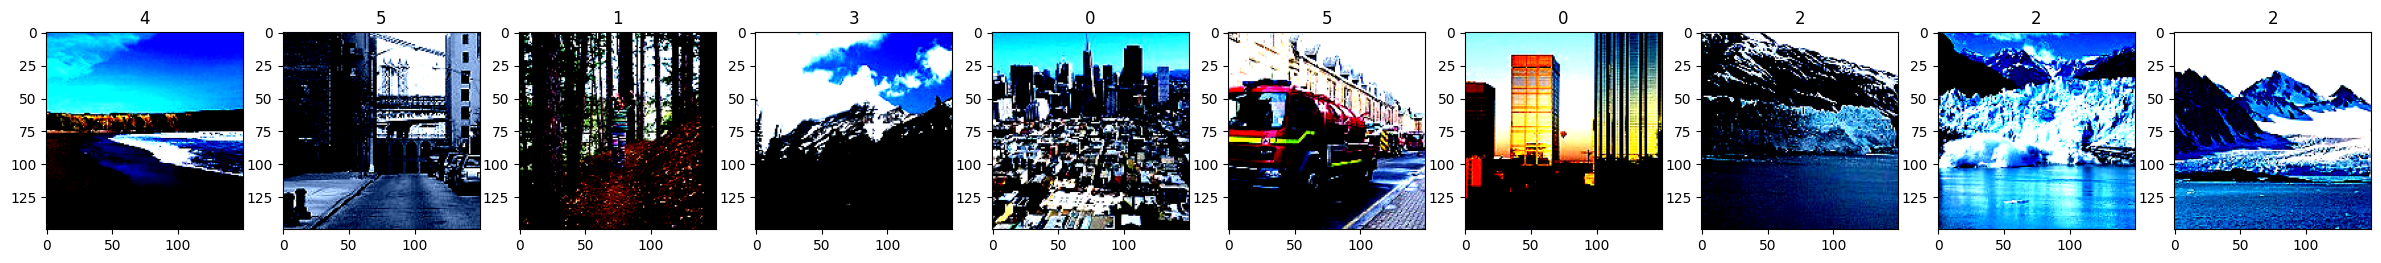

In [76]:
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
        axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(),
                                               (1, 2, 0))),
                       cmap='gray')
        axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)


Импортируем нужные модули для обучения сети:

In [77]:
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активации для слоев нейронных сетей
import torch.nn.functional as F

## Задание 2. Обучение сети с нуля. (4 балла код + 1 балл вывод)

Построим сверточную нейронную сеть, обучим ее и посчитаем метрику accuracy на тестовой выборке.

Так как в этом датасете картинки разрешения 150*150 -- больше, чем разрешение картинок из датасета с практического занятия -- то давайте построим сеть с тремя сверточными слоями и двумя макспуллингами.

In [78]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.Conv1 = nn.Conv2d(in_channels=3,
                               out_channels=5,
                              kernel_size=(3,3)
                          )
        self.Max_pol = nn.MaxPool2d(kernel_size=(2,2))
        self.Conv2 = nn.Conv2d(in_channels=5,
                               out_channels=4,
                              kernel_size=(3,3))
        self.Max_pol_2 = nn.MaxPool2d(kernel_size=(2,2))
        self.Conv3 = nn.Conv2d(in_channels=4,
                               out_channels=3,
                              kernel_size=(3,3))

        self.liniar_1 = nn.Linear(in_features = 3468,
                                  out_features = 256)
        self.liniar_2 = nn.Linear(in_features = 256,
                                  out_features = 6)




        # объявите слои: Conv-MaxPool-Conv-MaxPool-Conv.
        # Первый conv слой с 5 ядрами, второй -- с 4, третий -- с 3.
        # MaxPool оба с параметрами (2, 2)

        # YOUR CODE

        # после этого объявите два полносвязных слоя:
#         первый с 256 нейронами,
        # второй -- с 6 (выходной слой, 6 -- количество классов в датасете)
        # ВАЖНО! вам предстоит узнать, какое количество нейронов будет в первом
        # полносвязном слое после растягивания карт активации в вектор (Linear(?, 256))
        # проще всего это узнать, запустив обучение сети и посмотрев на текст ошибки:
        # в нем будет указано, сколько нейронов ожидается в линейном слое.
        # P.S. не забудтье Flatten!

        # YOUR CODE

    def forward(self, x):
        x = self.Conv1(x)
        x = nn.ReLU()(x)
        x = self.Max_pol(x)
        x = self.Conv2(x)
        x = nn.ReLU()(x)
        x = self.Max_pol_2(x)
        x = self.Conv3(x)
        x = nn.ReLU()(x)
        x = nn.Flatten()(x)
        x = self.liniar_1(x)
        x = nn.ReLU()(x)
        x = self.liniar_2(x)
        x = nn.Softmax()(x)

        # forward pass сети
        # напишите forward pass сети, используйте relu
        # в качестве промеждуточных активаций и softmax
        # в качестве активации последнего слоя

        return x

In [79]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.Conv1 = nn.Conv2d(in_channels=3,
                               out_channels=5,
                              kernel_size=(3,3)
                          )
        self.Max_pol = nn.MaxPool2d(kernel_size=(2,2))
        self.Conv2 = nn.Conv2d(in_channels=5,
                               out_channels=4,
                              kernel_size=(3,3))
        self.Max_pol_2 = nn.MaxPool2d(kernel_size=(2,2))
        self.Conv3 = nn.Conv2d(in_channels=4,
                               out_channels=3,
                              kernel_size=(3,3))

        self.liniar_1 = nn.Linear(in_features = 3468,
                                  out_features = 256)
        self.liniar_2 = nn.Linear(in_features = 256,
                                  out_features = 6)

        self.conv_part = torch.nn.Sequential(
            self.Conv1,
            nn.ReLU(),
            self.Max_pol,
            self.Conv2,
            nn.ReLU(),
            self.Max_pol_2,
            self.Conv3,
            nn.ReLU())

        self.classifire = torch.nn.Sequential(
          nn.Flatten(),
          self.liniar_1,
          nn.ReLU(),
          self.liniar_2,
          nn.Softmax())
        # объявите слои: Conv-MaxPool-Conv-MaxPool-Conv.
        # Первый conv слой с 5 ядрами, второй -- с 4, третий -- с 3.
        # MaxPool оба с параметрами (2, 2)

        # YOUR CODE

        # после этого объявите два полносвязных слоя:
#         первый с 256 нейронами,
        # второй -- с 6 (выходной слой, 6 -- количество классов в датасете)
        # ВАЖНО! вам предстоит узнать, какое количество нейронов будет в первом
        # полносвязном слое после растягивания карт активации в вектор (Linear(?, 256))
        # проще всего это узнать, запустив обучение сети и посмотрев на текст ошибки:
        # в нем будет указано, сколько нейронов ожидается в линейном слое.
        # P.S. не забудтье Flatten!

        # YOUR CODE

    def forward(self, x):
      x = self.conv_part(x)
      x = self.classifire(x)
        # forward pass сети
        # напишите forward pass сети, используйте relu
        # в качестве промеждуточных активаций и softmax
        # в качестве активации последнего слоя

      return x

In [80]:
conv_net = ConvNet()

In [81]:
conv_net.Conv1

Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))

In [82]:
conv_images = conv_net(images)
# conv_net.forward(images)

In [83]:
# conv_images

Тут, как обычно, функция обучения сети:

In [84]:
def train(net, n_epoch=5):
    # выбираем функцию потерь
    loss_fn = torch.nn.CrossEntropyLoss()

    # выбираем алгоритм оптимизации и learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

  # обучаем сеть 5 эпохи
    for epoch in tqdm_notebook(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm_notebook(train_dataiter)):
            # так получаем текущий батч
            X_batch, y_batch = batch

            # обнуляем градиенты
            optimizer.zero_grad()

            # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, y_batch)
            # bsckpropagation (вычисление градиентов)
            loss.backward()
            # обновление весов сети
            optimizer.step()

            # выведем текущий loss
            running_loss += loss.item()
            # выведем качество каждые 500 батчей
            if i % 10 == 9:
                print('[%d, %5d] loss: %.3f, acc: %3f' %
                    (epoch + 1, i + 1, running_loss / 500,
                     accuracy_score(y_batch.numpy(),
                                    np.argmax(y_pred.detach().numpy(),
                                              axis=1))))
            running_loss = 0.0

        print('Обучение закончено')
        return net

In [85]:
# объявляем сеть
net = ConvNet()
# теперь обучим сеть. Выберите нужное уоличество эпох для обучения.
# Постарайтесь подобрать его так, чтобы сеть не переобучилась, но и не недообучилась.
# можно поставить побольше эпох и остановить обучение, когда покажется нужным
net = train(net, n_epoch=3)#YOUR CODE)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

[1,    10] loss: 0.004, acc: 0.156250
[1,    20] loss: 0.004, acc: 0.218750
[1,    30] loss: 0.003, acc: 0.375000
[1,    40] loss: 0.003, acc: 0.468750
[1,    50] loss: 0.003, acc: 0.562500
[1,    60] loss: 0.003, acc: 0.468750
[1,    70] loss: 0.003, acc: 0.468750
[1,    80] loss: 0.003, acc: 0.468750
[1,    90] loss: 0.003, acc: 0.656250
[1,   100] loss: 0.003, acc: 0.531250
[1,   110] loss: 0.003, acc: 0.531250
[1,   120] loss: 0.003, acc: 0.593750
[1,   130] loss: 0.003, acc: 0.406250
[1,   140] loss: 0.003, acc: 0.593750
[1,   150] loss: 0.003, acc: 0.500000
[1,   160] loss: 0.003, acc: 0.718750
[1,   170] loss: 0.003, acc: 0.437500
[1,   180] loss: 0.003, acc: 0.531250
[1,   190] loss: 0.003, acc: 0.718750
[1,   200] loss: 0.003, acc: 0.656250
[1,   210] loss: 0.003, acc: 0.531250
[1,   220] loss: 0.003, acc: 0.500000
[1,   230] loss: 0.003, acc: 0.625000
[1,   240] loss: 0.003, acc: 0.468750
[1,   250] loss: 0.003, acc: 0.500000
[1,   260] loss: 0.003, acc: 0.656250
[1,   270] l

Посчитаем accuracy на test:

In [86]:
test_dataiter = iter(test_loader)
all_test = []
for images, labels in tqdm(test_dataiter):
  all_test.append(accuracy_score(labels.numpy(),
               np.argmax(net.forward(images).detach().numpy(), axis=1)))


100%|██████████| 94/94 [00:12<00:00,  7.67it/s]


In [87]:
np.mean(all_test)

0.582779255319149

In [88]:
result = np.argmax(net.forward(images).detach().numpy(), axis=1)

In [89]:
result = np.argmax(net.forward(images).detach().numpy(), axis=1)
# labels
# plt.hist(result)

In [90]:
# plt.hist(result)

In [91]:
accuracy_score(labels.numpy(),
               np.argmax(net.forward(images).detach().numpy(), axis=1))

0.5

**Задание:**
Вывод:

Проанализирейте: переобучилась ли ваша сеть? Достаточно ли хорошо она предсказывает картинки на тесте?

**Тут напишите ваш вывод**

## Задание 3. Дообучение AlexNet (2+2 балла код + 1 балл вывод)

Теперь давайте попробуем дообучить сеть, предобученную на ImageNet, на нашем датасете.

На практическом занятии мы дообучали Vgg16, теперь даватйе возьмем другую сеть -- AlexNet.

Список сетей, предобученных на ImageNet, которые есть в библиотеке PyTorch: https://pytorch.org/docs/stable/torchvision/models.html

In [92]:
from torchvision import models
AlexNet = models.alexnet(pretrained=True)

In [93]:
result = AlexNet(images)

In [94]:
AlexNet.parameters

<bound method Module.parameters of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=92

**Задание 3.1:**

Напишите класс New_AlexNet на основе AlexNet, у которой заменили последний слой. Заморозьте все слои, кроме слоев классификатора (всех линейных слоев)

In [95]:
class New_AlexNet(nn.Module):
    def __init__(self,
                 AlexNet):
        super().__init__()
        # забираем только сверточную часть из модели
        self.CNN = AlexNet.features
        # собираем наш классификатор
        # здесь нам нужен дропаут чтобы модель не так яростно переобучалась
        self.classifier = nn.Sequential(
            nn.Flatten(), # для перехода от сверточной части к полносвязной
            nn.Dropout(0.5),
            nn.Linear(in_features=2304,
                      out_features=1200, bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=1200,
                      out_features=300, bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=300,
                      out_features=6, bias=True),
            nn.Softmax()



        )


        # YOUR CODE

    def forward(self, x):
      x = self.CNN(x)
      x = self.classifier(x)

        # YOUR CODE

      return x

In [96]:
# применяем сверточную часть чтобы понять размерность
res = AlexNet.features(images)

In [97]:
print(nn.Flatten()(res).shape)
res.shape[1]*res.shape[2]*res.shape[3]

torch.Size([24, 2304])


2304

In [98]:
# net = New_AlexNet(AlexNet)
# #замораживаем градиенты в сверточной части
# net.CNN.requires_grad_(False)
# train(net, n_epoch=3)

In [58]:
#двухголовый класс
class New_AlexNet_2Head(nn.Module):
    def __init__(self,
                 AlexNet,
                 myCnn):
        super().__init__()
        # забираем только сверточную часть из модели
        self.CNN = AlexNet.features
        self.my_cnn = myCnn.conv_part
        # собираем наш классификатор
        # здесь нам нужен дропаут чтобы модель не так яростно переобучалась
        self.classifier = nn.Sequential(
            nn.Flatten(), # для перехода от сверточной части к полносвязной
            nn.Dropout(0.5),
            nn.Linear(in_features=5772, # цифра из конката
                      out_features=1200, bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=1200,
                      out_features=300, bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=300,
                      out_features=6, bias=True),
            nn.Softmax()



        )


        # YOUR CODE

    def forward(self, x):
      res_my_cnn = nn.Flatten()(self.my_cnn(x))
      res_alexnet = nn.Flatten()(self.CNN(x))
      full_embe = torch.concat((res_my_cnn,res_alexnet),dim=-1)

      result = self.classifier(full_embe)

        # YOUR CODE

      return result

In [59]:
# conv_net.parameters
multi_head_net = New_AlexNet_2Head(AlexNet,conv_net)

In [99]:
# код тут нужен только для анализа и отладки
# Я его оставил просто для понимания

multi_head_net.my_cnn(images).shape
multi_head_net.CNN(images).shape
# видим, что размерности совсем разные. Поэтому конкатить будем уже после
# перевода во флаттен

res_my_cnn = nn.Flatten()(multi_head_net.my_cnn(images))
res_alexnet = nn.Flatten()(multi_head_net.CNN(images))
torch.concat((res_my_cnn,res_alexnet),dim=-1).shape # -1 в dim значит что по последней оси

# дальше код переносим в forward

torch.Size([24, 5772])

In [100]:
#  проверяем работу
multi_head_net(images)

tensor([[0.0815, 0.3647, 0.1381, 0.0857, 0.2137, 0.1163],
        [0.1784, 0.1866, 0.1895, 0.0640, 0.2942, 0.0873],
        [0.1298, 0.2504, 0.1864, 0.1545, 0.1419, 0.1370],
        [0.1685, 0.2222, 0.2536, 0.0891, 0.0957, 0.1710],
        [0.1146, 0.2449, 0.1032, 0.0827, 0.3033, 0.1513],
        [0.1257, 0.1525, 0.0669, 0.1903, 0.2225, 0.2421],
        [0.2581, 0.2355, 0.1250, 0.0806, 0.1570, 0.1437],
        [0.2118, 0.1927, 0.1686, 0.1163, 0.1000, 0.2106],
        [0.2287, 0.2881, 0.1836, 0.0981, 0.0600, 0.1414],
        [0.0833, 0.1551, 0.1250, 0.1400, 0.1995, 0.2971],
        [0.1387, 0.1480, 0.2562, 0.1255, 0.1462, 0.1854],
        [0.1655, 0.1612, 0.1172, 0.1201, 0.1993, 0.2366],
        [0.1257, 0.1311, 0.1244, 0.1595, 0.3090, 0.1504],
        [0.1137, 0.1081, 0.0987, 0.1366, 0.4255, 0.1174],
        [0.2115, 0.2757, 0.1523, 0.1130, 0.1652, 0.0822],
        [0.1516, 0.1572, 0.1453, 0.1751, 0.1667, 0.2040],
        [0.1423, 0.1348, 0.1977, 0.1456, 0.1186, 0.2610],
        [0.127

In [102]:
# проверяем обучение
multi_head_net = train(multi_head_net, n_epoch=1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

[1,    10] loss: 0.003, acc: 0.343750
[1,    20] loss: 0.003, acc: 0.468750
[1,    30] loss: 0.003, acc: 0.531250
[1,    40] loss: 0.003, acc: 0.281250
[1,    50] loss: 0.004, acc: 0.156250
[1,    60] loss: 0.004, acc: 0.218750


KeyboardInterrupt: ignored

In [44]:
# labels

In [ ]:
# net(images)

И посмотрим на скор на тесте:

**Задание 3.3:** Вывод:

Какие результаты у вас получились? Классифицирует ли картинки природы лучше сеть, предобученная на ImageNet, или ваша сеть из задания два получилась лучше?
Есть ли разница между дообучением двух последних слоев сети или всех линейных слоев сети?

 **Тут напишите ваш вывод**

**Задание 4.1:** Соберем простой autoencoder:

Собираем автоэнкодер  - он состоит из 2х кусков.

Encoder - собирает из картинки эмбеддинг
Decoder должен вернуть в начальное состояние.
Зачем нам это может потребоваться ? В чем преимущество такой архитектуры ?

In [46]:
class autoencoder_base(nn.Module):
    def __init__(self):
        super().__init__()
        # YOUR CODE
        # self.Encoder = AlexNet.features
        self.Conv1 = nn.Conv2d(in_channels=3,
                               out_channels=5,
                              kernel_size=(3,3)
                          )
        self.Max_pol = nn.MaxPool2d(kernel_size=(2,2))
        self.Conv2 = nn.Conv2d(in_channels=5,
                               out_channels=4,
                              kernel_size=(3,3))
        self.Max_pol_2 = nn.MaxPool2d(kernel_size=(2,2))
        self.Conv3 = nn.Conv2d(in_channels=4,
                               out_channels=3,
                              kernel_size=(3,3))
        self.Encoder = torch.nn.Sequential(
            self.Conv1,
            nn.ReLU(),
            self.Max_pol,
            self.Conv2,
            nn.ReLU(),
            self.Max_pol_2,
            self.Conv3,
            nn.ReLU())

        self.Conv_trans_1 = nn.ConvTranspose2d(in_channels=3,
                               out_channels=4,
                              kernel_size=(3,3))
        self.Conv_trans_2 = nn.ConvTranspose2d(in_channels=4,
                               out_channels=5,
                              kernel_size=(3,3))
        self.Conv_trans_3 = nn.ConvTranspose2d(in_channels=5,
                               out_channels=3,
                              kernel_size=(3,3))



    def forward(self, x):
      # применили энкодер
      encoder_value = self.Encoder(x)
      #  применяем декодер по шагам
      x_decoder = self.Conv_trans_1(encoder_value)
      x_decoder = nn.ReLU()(x_decoder)
      x_decoder = F.interpolate(x_decoder, size=(38, 38),
                          mode='nearest')
      x_decoder = self.Conv_trans_2(x_decoder)
      x_decoder = nn.ReLU()(x_decoder)
      x_decoder = F.interpolate(x_decoder, size=(74, 74),
                          mode='nearest')
      x_decoder = self.Conv_trans_3(x_decoder)
      x_decoder = nn.ReLU()(x_decoder)
      x_decoder = F.interpolate(x_decoder, size=(150, 150),
                          mode='nearest')


      # decoder_value = self.Decoder(encoder_value)


        # YOUR CODE
      return x_decoder

In [47]:
autoencoder = autoencoder_base()

In [48]:
def train_autoencoder(net, n_epoch=5):
    # выбираем функцию потерь
    loss_fn = torch.nn.MSELoss()

    # выбираем алгоритм оптимизации и learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

  # обучаем сеть 5 эпохи
    for epoch in tqdm_notebook(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm_notebook(train_dataiter)):
            # так получаем текущий батч
            X_batch, _ = batch

            # обнуляем градиенты
            optimizer.zero_grad()

            # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, X_batch)
            # bsckpropagation (вычисление градиентов)
            loss.backward()
            # обновление весов сети
            optimizer.step()

            # выведем текущий loss
            running_loss += loss.item()
            # выведем качество каждые 500 батчей
            if i % 10 == 9:
                print(running_loss)
            running_loss = 0.0

        print('Обучение закончено')
        return net

In [49]:
train_autoencoder(autoencoder)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

1.5052708387374878
1.4726566076278687
1.349698781967163
1.4269611835479736
1.3430660963058472
1.2245949506759644
1.29464852809906
1.292099952697754
1.2651488780975342
1.0069035291671753
1.055023193359375
0.9344414472579956
1.0138555765151978
0.9119641780853271
0.9853050708770752
1.0555379390716553
0.980953574180603
0.9690519571304321
1.021097183227539
0.9838284850120544
0.9343067407608032
0.9574229121208191
0.9699028134346008
1.058346152305603
0.9725013971328735
0.9690103530883789
0.9781694412231445
0.9973558783531189
0.9823252558708191
1.0909743309020996
0.8377711176872253
0.9569488763809204
1.0526868104934692
0.9589821696281433
1.0353530645370483
0.8516154885292053
1.032564640045166
1.0470294952392578
0.9641605615615845
0.969742476940155
0.8558115363121033
1.0349420309066772
1.0334419012069702
Обучение закончено


autoencoder_base(
  (Conv1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
  (Max_pol): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (Conv2): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1))
  (Max_pol_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (Conv3): Conv2d(4, 3, kernel_size=(3, 3), stride=(1, 1))
  (Encoder): Sequential(
    (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(4, 3, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (Conv_trans_1): ConvTranspose2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (Conv_trans_2): ConvTranspose2d(4, 5, kernel_size=(3, 3), stride=(1, 1))
  (Conv_trans_3): Con

In [54]:
# забираем алекснет и от него потом лезем дальше
class autoencoder_Alexnet_base(nn.Module):
    def __init__(self,AlexNet):
        super().__init__()
        # YOUR CODE
        self.Encoder = AlexNet.features
        # сколько каналов было столько оставляем
        self.Conv_trans_1 = nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                              kernel_size=(3,3))
        self.Conv_trans_2 = nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                              kernel_size=(3,3))
        self.Conv_trans_3 = nn.ConvTranspose2d(in_channels=64,
                               out_channels=32,
                              kernel_size=(3,3))
        self.Conv_trans_4 = nn.ConvTranspose2d(in_channels=32,
                               out_channels=16,
                              kernel_size=(3,3))
        self.Conv_trans_5 = nn.ConvTranspose2d(in_channels=16,
                               out_channels=8,
                              kernel_size=(3,3))
        self.Conv_trans_6 = nn.ConvTranspose2d(in_channels=8,
                               out_channels=3,
                              kernel_size=(3,3))




    def forward(self, x):
      # применили энкодер
      encoder_value = self.Encoder(x)
      # теперь нам надо картинку развернуть
      x_decoder = self.Conv_trans_1(encoder_value)
      x_decoder = nn.ReLU()(x_decoder)
      #растим картинку не спеша
      #избегаем bottle neck
      x_decoder = F.interpolate(x_decoder, size=(9, 9),
                          mode='bilinear')
      x_decoder = self.Conv_trans_2(x_decoder)
      x_decoder = nn.ReLU()(x_decoder)
      x_decoder = F.interpolate(x_decoder, size=(24, 24),
                          mode='bilinear')
      x_decoder = self.Conv_trans_3(x_decoder)
      x_decoder = nn.ReLU()(x_decoder)
      x_decoder = F.interpolate(x_decoder, size=(72, 72),
                          mode='bilinear')
      x_decoder = self.Conv_trans_4(x_decoder)
      x_decoder = nn.ReLU()(x_decoder)
      x_decoder = F.interpolate(x_decoder, size=(100, 100),
                          mode='bilinear')
      x_decoder = self.Conv_trans_5(x_decoder)
      x_decoder = nn.ReLU()(x_decoder)
      x_decoder = F.interpolate(x_decoder, size=(120, 120),
                          mode='bilinear')
      x_decoder = self.Conv_trans_6(x_decoder)
      x_decoder = nn.ReLU()(x_decoder)
      x_decoder = F.interpolate(x_decoder, size=(150, 150),
                          mode='bilinear')


      # decoder_value = self.Decoder(encoder_value)


        # YOUR CODE
      return x_decoder

In [55]:
autoencoder_alexnet = autoencoder_Alexnet_base(AlexNet)
autoencoder_alexnet(images).shape # проверяем на то, что получили правильную по размерам картинку


torch.Size([24, 3, 150, 150])

In [56]:
train_autoencoder(autoencoder_alexnet)
# учится шумно. Возможно есть смысл добавить batchnorm (но можете не добавлять)
# еще вариант увеличить батч - можете тоже потестить

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

1.5824795961380005
1.5037426948547363
1.2708067893981934
1.476659893989563
1.25874924659729
1.0891532897949219
1.263258695602417
1.2830426692962646
1.1890743970870972
1.0481581687927246
1.1158661842346191
1.0994447469711304
1.0646576881408691
1.0289006233215332
0.9943468570709229
0.9067144393920898
1.0569941997528076
0.9707063436508179
0.9679073691368103
0.8813045024871826
0.927937924861908
0.9898781180381775
1.0392091274261475
0.8931347131729126
1.0910532474517822
0.9549226760864258
0.9921706914901733


KeyboardInterrupt: ignored

**Задание 4.2 :**  Давайте отрубим голову декодера и используем под нашу задачу.


In [ ]:
class Classifier_autoencoder_base(nn.Module):
    def __init__(self):
        super().__init__()
        # YOUR CODE

    def forward(self, x):

        # YOUR CODE

        return x

###### Что мы не рассматривали в этом ноутбуке, но в целом говорили.
Инициализация хорошим распределением
Скип-коннектионш
Разные оптимизаторы и работа с самим оптимизатором

In [ ]:
 #  тут код для разбивки данных на трейн и тест (если вы хотите это сделать сами)

!ls data_conv/

In [ ]:
import os
import shutil

In [ ]:
list_of_train = os.listdir('data_conv/seg_train')

In [ ]:
list_of_train

In [ ]:
!mkdir data_conv/seg_valid

In [ ]:
num_val_images_per_label = 10

In [ ]:
list_of_train = os.listdir('data_conv/seg_train') # смотрим на папочки которые мы должны использовать
train_folder_name = 'data_conv/seg_train'
val_folder_name = 'data_conv/seg_valid' #папка где должны лежать вал данные
os.mkdir(val_folder_name) # создаем папочку
for folder in list_of_train:
  list_of_files = os.listdir(train_folder_name+folder)
  os.mkdir(val_folder_name+'/'+folder) # создаем папочку
  val_list_files = np.random.choice(list_of_files,
                                    size=num_val_images_per_label,
                                    replace=False)
  for file in val_list_files:
      shutil.move(train_folder_name+'/'+folder+'/'+file,
                  val_folder_name+'/'+folder+'/'+file)


